<a href="https://colab.research.google.com/github/Javsk891/Sistemas-de-recomendacion/blob/main/Sistemas_de_recomendaci%C3%B3n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Sistemas de recomendación<h1>

Este notebook de Python implementa un sistema de recomendación sencillo, en donde se pretende exponer de forma clara y concisa los conceptos y el código para el desarrollo de un sistema de recomendación de productos para clientes, que podría ser usado en entornos de e-commerce, paginas de drop.shipping o incluso en tiendas con stock in-situ.

El sistema de recomendación es una herramienta poderos en los entornos antes mencionados ya que nos permite de antemano sugerir productos que podrían ser potencialmente comprados por los clientes, mejorando así la experiencia de los mismos y ayuadando a mejorar el desempeño en las ventas de nuestro negocio.

A continuación se explica y desarrolla código para dos sistemas sencillos de recomendació; uno en el que se desconoce totalmente las preferneicas del cliente (sistema de arranque en frío) y otro en el que de antemano, se conoce la preferencia del ususario por un producto en particular.

El caso de estudio es bastante sencillo, pues el objetivo es conocer previamente los conceptos, librerías y funciones que se ussan en este tipo de desarrollo, para que luego puedan ser utilizados en sistemas de recomendación mas robustos y sofisticados

#Recomendaciones basada en popularidad

Para este caso, el más sencilllo, cuando trabajamos con sistemas de recomendación, no se cononce inicialmente nada a cerca del ususario, entonces se procede simplemente a recomendar los articulos según su popularidad reflejada a través de las calificaiones que otros usuarios han hecho sobre el articulo o producto.

Esta dilema, cuando se quiere ahcer una recomendación sin tener un conocimiento previo a cerca del cliente es conocido como: "Cold start problem" o en español; problema de arranque en frío.

En este caso, no se tienen los elementos para hacer ningún tipo de recomendación personilizada, y se procede a realizar simplemente la recomendación de los articulos o items más populares.

Los datos que usaremos en este problema especifico, serán sobre las transacciones de un determinado número de productos, que facilitaran la identificación de los productos más populares, que serán los recomendados a los nuevos clientes.


In [20]:
###############################################################################
############################## Data Wrangling #################################
###############################################################################

#Leemos desde internet un archivo csv y lo almacenamos en un DataFrame de Pandas
import pandas as pd #Importamos pandas para la lectura de los datos a utilizar.
import numpy as np #Importamos numpy para el manejo de los datos.

interacciones = pd.read_csv('https://bradfordtuckfield.com/purchasehistory1.csv') #Definimos la variable 'Interacciones' donde se almacenarán las interacciones registradas entre los clientes y los productos.
interacciones.set_index('Unnamed: 0', inplace = True) #Establecemos la columna que contiene los items como el índice.
print(interacciones)

#Obtenemos la matriz de interacciones

            user1  user2  user3  user4  user5
Unnamed: 0                                   
item1           1      1      0      1      1
item2           1      0      1      1      0
item3           1      1      0      1      1
item4           1      0      1      0      1
item5           1      1      0      0      1


Obtenemos la matriz de interacciones, en donde un valor de '0' signifaca que un producto no fue seleccionado por el cliente y un valor de '1' indica que el producto si fue seleccionado por el cliente.

Una vez obtenemos la matriz de interacciones, creamos una lista con los items mas populares para proceder a recomendar dichos productos

In [21]:
#Ratind de productos
conteo_interacciones = interacciones.copy()
conteo_interacciones.loc[:, 'conteo'] = conteo_interacciones.sum(axis = 1) #Toma la suma de de los productos seleccionados en cada fila y guarda el resultado en una nueva columna llamada conteo
conteo_interacciones = conteo_interacciones.sort_values(by='conteo', ascending = False) #Organiza las filas de la más a la menos popular
print(list(conteo_interacciones.index)) #Imprimimos el rating de los productos

['item1', 'item3', 'item2', 'item4', 'item5']


Una vez obtenido el rating de los productos, ahora podemos proceder a hacer las recomendaciones a los clientes. La forma en que se presentan las recomendaciones depende de la estrategía de marqueting utilizada

In [22]:
#Creando el sistema de recomendaciones
def popularidad(interacciones): #Creamos la función para determinar la popularidad de los productos
  conteo_interacciones = interacciones.copy() #Creamos una copia de la matriz de interacciones
  conteo_interacciones.loc[:, 'conteo'] = conteo_interacciones.sum(axis = 1)
  ranking = conteo_interacciones.sort_values(by = 'conteo', ascending = False) #Aquí obtenemos el ranking ene orden ascendente de los productos más populares
  mas_populares = list(ranking.set_index)
  return(mas_populares)

#Filtrado Colaborativo Basado en Elementos

Para este caso no se tiene en sí un problema de arranque en frío, en cambio se tiene un poco de información sobre los usuarios, por ejemplo, se sabe que estan interesados particularmente en el 'item 1'. Esta información es todo lo que necesitas para desarrollar un sistema de filtrado colaborativo basado en elementos.

Demos un vistazo nuevamente a nuestra matriz de interacciones para hacerno a una idea de como se podría recomendar por ejemplo, a un usuario que este interesado en el item 1.

In [23]:
print(interacciones) #Imprimimos la matriz de interacciones

            user1  user2  user3  user4  user5
Unnamed: 0                                   
item1           1      1      0      1      1
item2           1      0      1      1      0
item3           1      1      0      1      1
item4           1      0      1      0      1
item5           1      1      0      0      1


Si observamos la fila 1 de la matriz de interacciones, podemos notar que todos los usuarios, menos el usuarios 3 'user3' estan interesados en el item1. Si analizamos el item3, podemos observas que tiene exactamente el mismo historial de interacciones del item1. Podemos concluir que se estos dos productos fueron seleccionados por los usuarios de igual forma en el pasado, el evento podría repetirse en el futuro.

De igual forma, si analizamos el historial de interacciones de los items 1 y 2, se puede concluir que si no fueron seleccionados de igual forma en el pasado, muy seguramente no sucedera así, en el futuro.

El hecho es, que si un usuario esta interesado en un articulo o producto, tendría logica recomendarle productos que tengan un hostorial de interacciones lo más parecido, al historial del producto sobre el cual se sabe que ya había tenido algún interes.

Para llevar a cabo esto, se puede medir la similaridad entre los vectores.


###Similaridad entre vectores

Miremos de más cerca el historial de interacciones de un item, para tener una idea de como puede medirse cuantitativamente su similaridad

In [24]:
print(list(interacciones.loc['item1'])) #Imprimimos el historial de interacciones del

[1, 1, 0, 1, 1]


Python interperta esta colección de interacciones como una lista. Otra forma de interpretarla sería como una matriz. Más importante aún, podemos interpretarlo como un vector. A este conjunto de vectores podemos cuantificarle su similaridad.

El menor angulo posible entre dos vectores es cero '0', lo que significa que significa que estos apuntan exactamente hacia la misma dirección (Estan sobrepuestos)

Para este caso la función coseno es sumamente importnate y es a través de la cuál nos valdremos para calcular dicha similitud entre los pares de vectores que representan las interacciones para cada producto

###Calculando La Similaridad Coseno

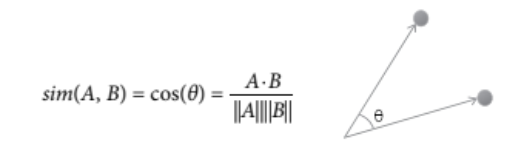

Las siguientes líneas de código representan el producto punto. Una forma particular de multiplicar vectores. Para calcular la similitud Coseno debemos tambíen calcular la norma del vector.

El Coseno del angulo entre dos vectores (que es, la similaridad coseno entre dos vectores) es el producto punto del par de vectores divido entre el producto de la norma de los vectores. Podemos crear una función de Python que calcule la similaridad coseno, usando un par de funciones que se definen en las siguientes líneas de código.

In [25]:
###############################################################################
############################# Similitud Coseno ################################
###############################################################################

#Producto Punto
def el_producto_punto(vector1, vector2):
  producto_punto = np.sum([vector1[k]*vector2[k] for k in range(0, len(vector1))])
  return(producto_punto)

In [26]:
#Norma del vector
def vector_norm(vector):
  norma = np.sqrt(el_producto_punto(vector, vector))
  return(norma)

In [27]:
#Similaridad Coseno
def similaridad_coseno(vector1, vector2):
  producto_punto = el_producto_punto(vector1, vector2)
  coseno = producto_punto/(vector_norm(vector1)*vector_norm(vector2))
  coseno = np.round(coseno, 4)
  return(coseno)

###Similaridad Coseno entre los items de nuestro ejemplo

La similaridad coseno, es la similitud común que calculan muchas aplicaciones de en Ciencia de Datos, no solo para sistemas de recomendación. Ahora vamos a utilizar la fucnión que acabamos de desarrollar para calcular a similaridad usando los vectores asociados a las distintas colecciones de interacciones para los items del sistema de recomendación que estamos desarrollando.

Como se ppodrá observar, la similaridad coseno entre el item1 y el item3 es de 1, es decir, el angulo entre el par de vectores es cero '0' lo que confirma que dichos items tienen exactamente el mismo historial de interacciones.

In [28]:
import numpy as np #Impotamos numpy para el procesamiento de los datos
item1 = interacciones.loc['item1'] #Definimos el vector asociado al item1
item3 = interacciones.loc['item3'] #Definimos el vector asociado al item3
print(similaridad_coseno(item1, item3))

1.0


<ipython-input-25-aa5b6c6c22f6>:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  producto_punto = np.sum([vector1[k]*vector2[k] for k in range(0, len(vector1))])


De igual manera podemos calcular la similaridad coseno para un par de vectores que nos sean exactamente iguales. observemos el caso para el par de vectores asociados a los items 2 y 5 (item2, item5).

Como es de esperarse, se observa que el resultado para la similaridad coseno del par de vectores asociados a los items 2 y 5 (item2, item5) nos arroja un resultado diferente de 1, ya que el angulo entre estos es diferente de cero '0', confirmando que los items tienen un grado de similitud, pero no son exactamente identicos

In [29]:
item2 = list(interacciones.loc['item2', :])
item5 = list(interacciones.loc['item5', :])
print(similaridad_coseno(item2, item5))

0.3333


##Implementación del sistema de filtrado colaborativo basado en elementos

Pensemos en un escenario hipotetico de ventas con su respectivo vendedor, donde tienes tu respectiva matriz de interacciones que describe la elecciones que han hecho los clientes respectos a varios productos (items). Ahora ingresa un nuevo cliente al escenario descrito y la unica información que se tiene sobre el es que tiene interes en el item1. ¿Que recomendación deberías hacerle?

Puedes hacer el ranking de similitud en el historial de interacciones de dicho articuo 'item1' resoecto a los demás articulos (items) y recomendarle los productos en base a dicha similitud respecto al artiuclo de su interes (item1)

In [30]:
articulo_de_interes = 'item1' #Creamos la variable 'articulo_de_interes' para almacenar el item de interes que ya se conoce sobre el nuevo cliente
otros_articulos = [nombre_articulo for nombre_articulo in interacciones.index if nombre_articulo != articulo_de_interes]
otros_articulos = interacciones.loc[otros_articulos, :]
el_articulo = interacciones.loc[articulo_de_interes, :]

Ahora podremos calcular que tan similares son cada uno de los articulos coleccionados dentro de nuestra base de datos y hacer las respectivas recomnedaciones a los nuevos clientes, basados en que tan similares sea el articulo de interes que conocemos de antemano, con los otros articulos de nuestro stock

In [31]:
similaridades = [] #Creamos una lista vacia en donde se almacenarán los artiuclos similares que deberían recomendarse al nuevo cliente
for articulos in otros_articulos.index:
  similaridades.append(similaridad_coseno(el_articulo, otros_articulos.loc[articulos, :]))

otros_articulos['Similaridades'] = similaridades
recomendaciones = list(otros_articulos.sort_values(by = 'Similaridades', ascending = False).index)

<ipython-input-25-aa5b6c6c22f6>:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  producto_punto = np.sum([vector1[k]*vector2[k] for k in range(0, len(vector1))])


En las líneas de código arriba, creamos la varaiable similaridades, que comienza como uan lista vacia. Luego creamos un loop que calcula la similaridad coseno entre nuestro producto y todos los demás productos disponibles en el stock. Finalmente obtenemos nuestra lista de recomendaciones. Unam lista que muestra los articulos más similares al articulo cuya preferencia por parte del usuario ya era conocida

In [40]:
def recomendación_articulos(interacciones, nombre_articulo):
  otras_filas = [nombre_articulo_rec for nombre_articulo_rec in interacciones.index if nombre_articulo_rec != nombre_articulo]
  otros_articulos = interacciones.loc[otras_filas, :]
  el_articulo = list(interacciones.loc[nombre_articulo, :])
  similaridades = []
  for articulos in otros_articulos.index: # Iteración sobre el índice del dataframe
    similaridades.append(similaridad_coseno(el_articulo, otros_articulos.loc[articulos, :]))
  otros_articulos['Similaridades'] = similaridades
  return list(otros_articulos.sort_values(by = 'Similaridades', ascending = False).index)

Ahora podemos probar nuestro sistema de recomendación que nos arrojará una lista con los items que se podrían recomendar a un nuevo cliente del cual se sabe previamente que tenia cierta preferncia por el item1 de nuestro stock

In [41]:
recomendación_articulos(interacciones, 'item1')

<ipython-input-25-aa5b6c6c22f6>:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  producto_punto = np.sum([vector1[k]*vector2[k] for k in range(0, len(vector1))])


['item3', 'item5', 'item2', 'item4']